In [2]:
from perfetto.trace_processor import TraceProcessor
import numpy as np
import matplotlib.pyplot as plt

### Trace analysis, using counter trackers

Follow [this](https://perfetto.dev/docs/quickstart/trace-analysis) link for more understanding on counter trackers. We need tracker indexes for modem, frontend, mmWave and display (for benchmarking). Which are:

    1. 'power.rails.modem': 2
    2.'power.rails.radio.frontend': 3
    3. 'power.rails.VSYS_PWR_MMWAVE_uws': 1
    4. 'power.rails.display': 13

In [4]:
# Initialise TraceProcessor with a trace file
# tp = TraceProcessor(trace='trace_iperf.perfetto-trace')
# tp = TraceProcessor(trace='trace_5M_band66.perfetto-trace')
tp = TraceProcessor(trace='ping_trace_rxping.perfetto-trace') #10-15 dBm

# print(tp)
qr_it = tp.query('SELECT * FROM counter_track')
# print(qr_it)
qr_it_pandas = qr_it.as_pandas_dataframe()
print(qr_it_pandas)

# qr_it_pd2 = qr_it_pandas.filter(regex='power.rails.display')
# print(qr_it_pandas[qr_it_pandas['name']=='power.rails.display'])
# for row in qr_it:
#   print(row.id, row.type, row.name)

id_mapper = [2,3,1,13]
string_mapper = ["Modem","RFE","mmWave","Display"]

    id           type                          name parent_id  \
0    1  counter_track     power.VSYS_PWR_MMWAVE_uws         0   
1    2  counter_track             power.rails.modem         0   
2    3  counter_track    power.rails.radio.frontend         0   
3    4  counter_track  power.rails.memory.interface         0   
4    5  counter_track           power.rails.cpu.big         0   
5    6  counter_track           power.rails.cpu.mid         0   
6    7  counter_track        power.rails.cpu.little         0   
7    8  counter_track     power.rails.system.fabric         0   
8    9  counter_track           power.S8M_LLDO2_uws         0   
9   10  counter_track      power.L15M_VDD_SLC_M_uws         0   
10  11  counter_track               power.rails.tpu         0   
11  12  counter_track           power.S6M_LLDO1_uws         0   
12  13  counter_track           power.rails.display         0   
13  14  counter_track           power.rails.wifi.bt         0   
14  15  counter_track    

Text(0.5, 0.98, 'Raw Values, can be checked with Perfetto UI')

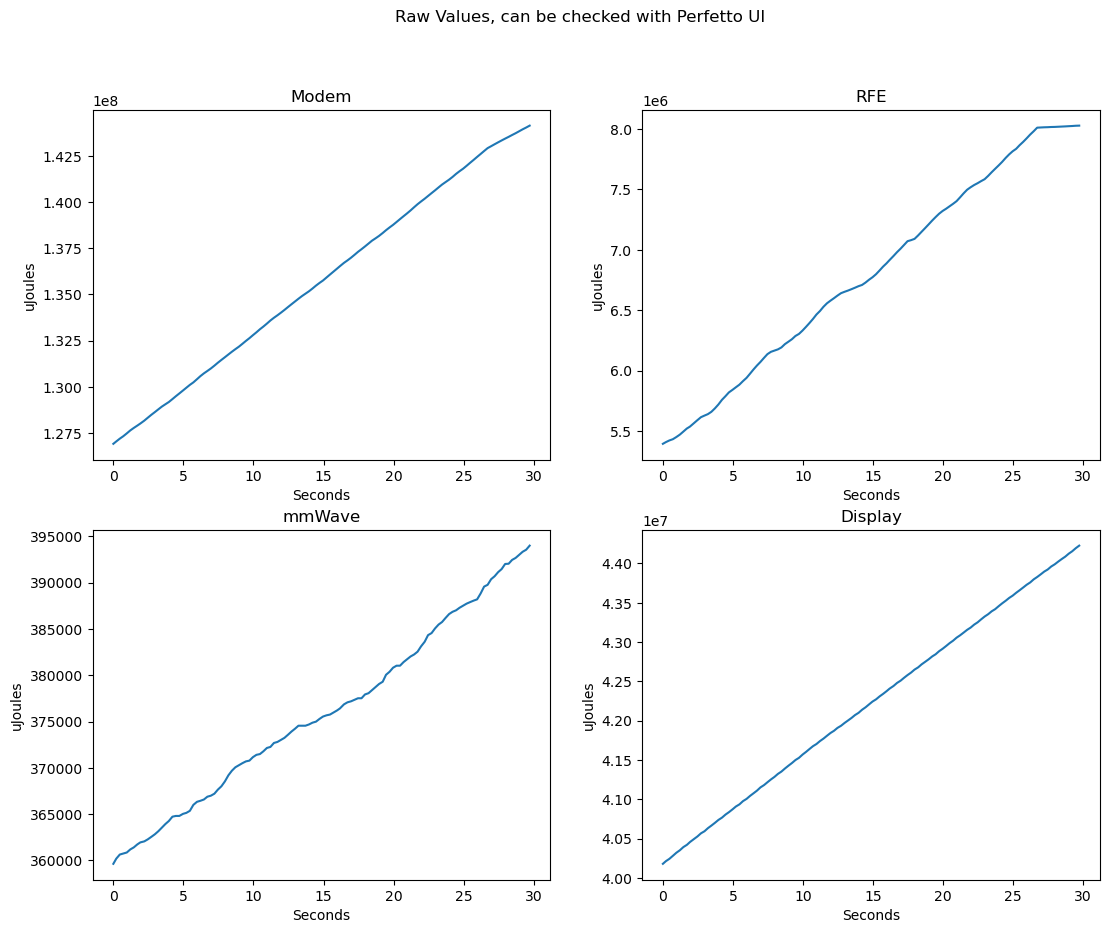

In [5]:
df_list_cleaned = [tp.query('SELECT ts,value FROM counter WHERE track_id='+str(i)+'')
                   .as_pandas_dataframe().replace(np.nan,0)
                   .values.tolist() for i in id_mapper]
# import pdb;pdb.set_trace()
df_np = np.array(df_list_cleaned)
df_np[:,:,0] = df_np[:,:,0] - np.tile(df_np[:,0,0],[df_np.shape[1],1]).T 
df_np[:,:,0] = df_np[:,:,0]/1e9
# import pdb; pdb.set_trace()
plt.rcParams['figure.figsize'] = [13, 10]
for i in range(1,5):
    plt.subplot(2,2,i)
    x_vals = df_np[i-1,:,0]
    y_vals = df_np[i-1,:,1] 
    plt.plot(x_vals,y_vals)
    plt.xlabel("Seconds")
    plt.ylabel("uJoules")
    plt.title(string_mapper[i-1])
plt.suptitle("Raw Values, can be checked with Perfetto UI")

Average Power (mW) for Modem: 579.468779661017 mW
Average Power (mW) for RFE: 88.75142372881353 mW
Average Power (mW) for mmWave: 1.145322033898305 mW
Average Power (mW) for cellular (total): 669.3655254237287 mW
Average Power (mW) for Display: 135.968 mW


Text(0.5, 0.98, 'Delta Values, can be checked with Android Studio')

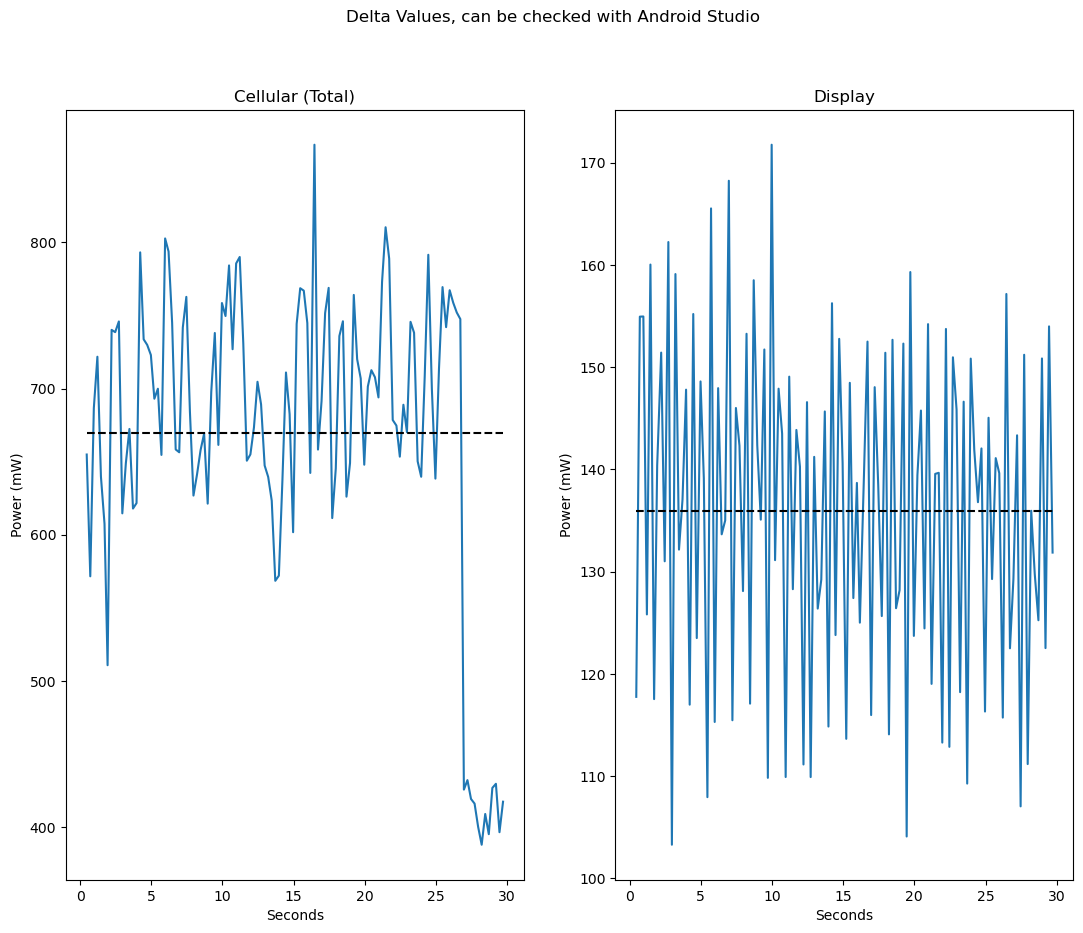

In [6]:
string_mapper_AS = ["Cellular (Total)","Display"]
plt.rcParams['figure.figsize'] = [13, 10]
summed_vals=np.zeros(df_np.shape[1])
initial_offset = 2
for i in range(1,5):
    x_vals = df_np[i-1,:,0]
    y_vals = df_np[i-1,:,1]
    delta_y_vals = np.copy(y_vals)
    delta_y_vals[1:] = delta_y_vals[1:]-delta_y_vals[0:y_vals.size-1]
    delta_y_vals[0] = 0
    avg_pow_indiv = np.mean(delta_y_vals[initial_offset:]*(4/1000))
    print("Average Power (mW) for "+str(string_mapper[i-1])+": "+str(avg_pow_indiv)+" mW")
#     import pdb; pdb.set_trace()
    if(i<=3):
        summed_vals = summed_vals + delta_y_vals
        if(i==3):
            plt.subplot(1,2,i-2)
            # *4 because power measurements done roughly over 250ms (1/4 seconds) interval
            # Making it mW by dividing by 1000
            plt.plot(x_vals[initial_offset:],summed_vals[initial_offset:]*(4/1000))
            avg_pow = np.mean(summed_vals[initial_offset:]*(4/1000))
            print("Average Power (mW) for cellular (total): "+str(avg_pow)+" mW")
            min_time = np.min(x_vals[initial_offset:])
            max_time = np.max(x_vals[initial_offset:])
            plt.plot([min_time,max_time],[avg_pow,avg_pow], linestyle="--", color="black")
            plt.xlabel("Seconds")
            plt.ylabel("Power (mW)")
            plt.title(string_mapper_AS[i-3])
#         summed_vals = 0
    else:
        plt.subplot(1,2,i-2)
        # *4 because power measurements done roughly over 250ms (1/4 seconds) interval
        plt.plot(x_vals[initial_offset:],delta_y_vals[initial_offset:]*(4/1000))
        min_time = np.min(x_vals[initial_offset:])
        max_time = np.max(x_vals[initial_offset:])
        plt.plot([min_time,max_time],[avg_pow_indiv,avg_pow_indiv], linestyle="--", color="black")
        plt.xlabel("Seconds")
        plt.ylabel("Power (mW)")
        plt.title(string_mapper_AS[i-3])
    
plt.suptitle("Delta Values, can be checked with Android Studio")